<h1> Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
# !pip3 install higher
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings

ax_size = 14
title_size = 16

<h1> Data Loading and Generation

In [3]:
'''
Create a master data class to ensure analogous structure across tasks
Help on writing abstract classes from: 
https://www.geeksforgeeks.org/abstract-classes-in-python/

Meta-train has training and test sets
Also have meta-val and meta-test sets (at the task level)
Help for understanding training and test set structure from [see especially for classification]: 
https://meta-learning.fastforwardlabs.com/


What do we want out of our data generation code? 
- specify a particular task instance
(e.g., amplitude and phase; N number of discrete classes)
- extract batches of tasks for train, val, and test
- extract sample from a given task of size K for training (and other for testing)
'''

class Domain(): 
    
    def get_meta_train_batch(self, task_batch_size):
        # yields the set of meta-training tasks, each of which has train and test sets
        pass 
    
    def get_meta_val_batch(self, task_batch_size):
        # yields meta-val tasks (each just has a single data set)
        pass

    def get_meta_test_batch(self, task_batch_size):
        # yields meta-test tasks (each just has a single data set)
        pass
    
'''
Regression task, as per MAML Section 5.1 (https://arxiv.org/pdf/1703.03400.pdf)
Specifically, sine wave generation 

Code inspired by and modified from: 
https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Checked original MAML code to ensure resampling for all stages of sinusoid:
https://github.com/cbfinn/maml/blob/master/data_generator.py
'''

class RegressionDomain(Domain): 
    
    '''
    Each task is a sine wave
    Parameterized by amplitude and phase 
    Always drawn from w/in a specified range of x vals
    [Values from Section 5.1 -- but we could vary??]
    '''
    
    def __init__(self, amp_min=0.1, amp_max=0.5, 
                 phase_min=0, phase_max=PI,
                train_size=1000, val_size=100, test_size=1000): 
        
        self.amp_min = amp_min
        self.amp_max = amp_max
        self.phase_min = phase_min
        self.phase_max = phase_max
        
        # create initial train, val, and test 
        # parameters specify the number of unique functions we want
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        # looping to instantiate tasks idea from: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
        # help on generating random numbers in range from: https://pynative.com/python-get-random-float-numbers/
        self.tasks = {}
        # note: code would be more structured b/w task type for classification
        for task_type, num_tasks in zip(["train", "val", "test"], [train_size, val_size, test_size]):
            tasks = [SineFunction(amplitude = random.uniform(self.amp_min, self.amp_max), 
                                     phase=random.uniform(self.phase_min, self.phase_max)) for _ in range(num_tasks)]
            self.tasks[task_type] = tasks
    
    def get_batch_of_tasks(self, task_type, task_batch_size): 
        # helper function since same sampling per type for regression-specific domain
        if task_batch_size is None: 
            # return all 
            return self.tasks[task_type]
        else: 
            # sub-sample
            # note: we could investigate impact of weighted sub-sampling in batch (?)
            # see documentation: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
            task_batch = np.random.choice(self.tasks[task_type], size=task_batch_size, replace=False)
            return task_batch
    
    def get_meta_train_batch(self, task_batch_size=10): 
        return self.get_batch_of_tasks("train", task_batch_size)
        
    def get_meta_val_batch(self, task_batch_size=None): 
        return self.get_batch_of_tasks("val", task_batch_size) 
        
    def get_meta_test_batch(self, task_batch_size=None): 
        return self.get_batch_of_tasks("test", task_batch_size)

        
class SineFunction(): 
    
    def __init__(self, amplitude, phase): 
        self.amplitude = amplitude
        self.phase = phase
        
    def draw_sample(self, x): 
        '''
        Sample from the specified sine wave 
        '''
        # help to sample from a sine function:
        # https://stackoverflow.com/questions/48043004/how-do-i-generate-a-sine-wave-using-python
        freq = 1 # TODO: check???
        return self.amplitude * np.sin(freq * x + self.phase)
    
    def get_samples(self, num_samples=10, 
                    min_query_x=-5.0, max_query_x=5.0): 
        '''
        Return samples drawn from this specific function (e.g., K for training set in meta-train)
        Note, input range uses values from paper (Section 5.1)
        But modification allowed thru function so we can test generalization beyond??
        '''
        x_vals = [random.uniform(min_query_x, max_query_x) for _ in range(num_samples)]
        y_vals = [self.draw_sample(x) for x in x_vals]
        # conversion to tensor idea and code help from: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
        return {"input": torch.Tensor(x_vals), "output": torch.Tensor(y_vals)}
        

<h1> Neural Network Model

In [4]:
# Define network
class Neural_Network(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=1):
        super(Neural_Network, self).__init__()
        # network layers
        self.hidden1 = nn.Linear(input_size,hidden_size)
        self.hidden2 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size,output_size)

        #Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        y = x
        return y


<h1> Helper functions

In [20]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def get_samples_in_good_format(wave, num_samples=10):
    #This function is used to sample data from a wave
    sample_data = wave.get_samples(num_samples=num_samples)
    x = sample_data["input"]
    y_true = sample_data["output"]
    # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
    # Note that we convert everything torch tensors
    x = torch.tensor(x[:,None])
    y_true = torch.tensor(y_true[:,None])
    return x,y_true
#     # set to whatever the base device is (GPU or CPU)
#     # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
#     return x.to(device),y_true.to(device) 

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model,losses = training(model, wave, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, wave)
    # Store loss
    store_test_loss_meta.append(loss)
    return losses

def train_set_evaluation(new_model,wave,store_train_loss_meta):
    loss = evaluation(new_model, wave)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, item = True):
    # Get data
    x, label = get_samples_in_good_format(wave)
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,label).item()
    else:
      loss = criterion(prediction,label)
    return loss

def training(model, wave, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    losses = []
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
        losses.append(loss.item())
    return new_model, losses

<h1> Reptile

In [11]:
#Define important variables
epochs = int(1e5) # number of epochs 
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=1000 # how many epochs should we wait to print the loss
lr_k=0.01 # Internal learning rate
k=5 # Number of internal updates for each task

# Initializations
initialization_to_store_meta_losses()
model = Neural_Network()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [12]:
# using parameters from original MAML Section 5.1 (https://arxiv.org/pdf/1703.03400.pdf)
amp_min=0.1
amp_max=5.0
phase_min=0
phase_max=PI
K = 10

meta_train_size=1000
meta_val_size=100
meta_test_size=1000
meta_train_eval_size = 20

task_batch_size = 10  

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

meta_train_sample = dataset.get_meta_train_batch(task_batch_size=task_batch_size)

meta_train_sample[0].get_samples()

{'input': tensor([ 4.9709, -0.1401,  1.2311,  4.1330, -2.8615,  2.8029,  3.8531, -3.7313,
         -3.8877, -3.8172]),
 'output': tensor([ 1.5082,  4.0338,  0.8611, -1.7719, -3.7084, -3.9422, -2.7042, -3.6058,
         -3.2800, -3.4373])}

In [13]:
# Training loop
for epoch in range(epochs):
        
    # Sample a sine wave (Task from training data)
    wave = dataset.get_meta_train_batch(task_batch_size=1)#wave = random.sample(SINE_TRAIN, 1)

    # Update model predefined number of times based on k
    new_model,_ = training(model, wave[0], lr_k, k)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,wave[0],store_train_loss_meta)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the wave from the test data
    wave = dataset.get_meta_val_batch(task_batch_size=1)#wave = random.sample(SINE_TEST, 1)
    test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

<ipython-input-10-12ae40307b21>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-10-12ae40307b21>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])
<ipython-input-10-12ae40307b21>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parameter.grad = torch.tensor(torch.zeros_like(parameter))


Epochh : 0, Average Train Meta Loss : 7.478808403015137, Average Test Meta Loss : 4.267937183380127
Epochh : 1000, Average Train Meta Loss : 2.216651119131755, Average Test Meta Loss : 2.74260658747912
Epochh : 2000, Average Train Meta Loss : 1.7268342335235098, Average Test Meta Loss : 2.0666405896775832
Epochh : 3000, Average Train Meta Loss : 1.4600633438170745, Average Test Meta Loss : 1.7411175031697217
Epochh : 4000, Average Train Meta Loss : 1.2691587046604864, Average Test Meta Loss : 1.5022620122066903
Epochh : 5000, Average Train Meta Loss : 1.1221323363646647, Average Test Meta Loss : 1.3160355743107834
Epochh : 6000, Average Train Meta Loss : 1.006336556598569, Average Test Meta Loss : 1.1716582864555758
Epochh : 7000, Average Train Meta Loss : 0.915831670078029, Average Test Meta Loss : 1.0565290810437422
Epochh : 8000, Average Train Meta Loss : 0.842000216348375, Average Test Meta Loss : 0.9649435884980461
Epochh : 9000, Average Train Meta Loss : 0.7748058336264564, Avera

Epochh : 77000, Average Train Meta Loss : 0.15051545527683094, Average Test Meta Loss : 0.16691708948556716
Epochh : 78000, Average Train Meta Loss : 0.1490085279135063, Average Test Meta Loss : 0.16526329774409296
Epochh : 79000, Average Train Meta Loss : 0.14756034040174684, Average Test Meta Loss : 0.16361415516816952
Epochh : 80000, Average Train Meta Loss : 0.14616135563978486, Average Test Meta Loss : 0.1620796431157788
Epochh : 81000, Average Train Meta Loss : 0.14479022951074905, Average Test Meta Loss : 0.16052348758344043
Epochh : 82000, Average Train Meta Loss : 0.14341978740520106, Average Test Meta Loss : 0.15903916797689277
Epochh : 83000, Average Train Meta Loss : 0.14206659186480441, Average Test Meta Loss : 0.1575486296456015
Epochh : 84000, Average Train Meta Loss : 0.14074475253996244, Average Test Meta Loss : 0.15613359298452012
Epochh : 85000, Average Train Meta Loss : 0.1394943728489158, Average Test Meta Loss : 0.15471475348299982
Epochh : 86000, Average Train Me

<h1> Few Shot learning with new meta-model

<ipython-input-20-94f2234b00e2>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-20-94f2234b00e2>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])


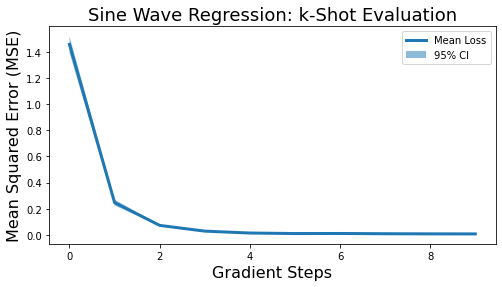

In [25]:
# wave = dataset.get_meta_val_batch(task_batch_size=1)#wave = random.sample(SINE_TEST, 1)
#     test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta)

all_losses = []
num_eval = 100 
num_k_shots = 10

test_waves = dataset.get_meta_test_batch(task_batch_size=num_eval)
for test_eval in range(num_eval): 
    test_wave = test_waves[test_eval]
    metaTrainLosses = test_set_validation(model,new_model,wave[0],lr_k,num_k_shots,store_test_loss_meta)
    all_losses.append(np.array(metaTrainLosses))
    

all_losses = np.array(all_losses)
np.save(f"reptile_sine_{num_k_shots}.npy", all_losses)
    
fig, ax = plt.subplots(figsize=(8,4))

mean_loss = np.mean(all_losses, axis=0)

# confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
y = mean_loss
x = list(range(num_k_shots))
ci = 1.96 * np.std(all_losses, axis=0)**2/np.sqrt(len(y))

ax_size=16
title_size=18
                                                  
ax.plot(x, y, linewidth=3, label=f"Mean Loss")
# to avoid having MSE < 0
truncated_error = np.clip(y-ci, a_min=0, a_max=None)
ax.fill_between(x, truncated_error, (y+ci), alpha=.5,label=f"95% CI")

ax.set_xlabel("Gradient Steps",fontsize=ax_size)
ax.set_ylabel("Mean Squared Error (MSE)",fontsize=ax_size)
ax.set_title("Sine Wave Regression: k-Shot Evaluation",fontsize=title_size)
ax.legend()#loc="upper right")
plt.savefig("reptile_sine_wave_reg_kshot.png")
# ax.set_ylim([0,7])

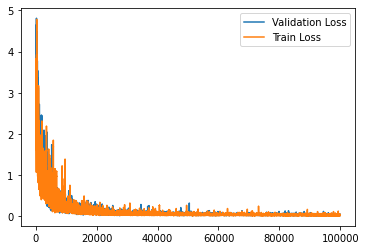

In [27]:
num = 20
avgTrain = []
avgVal = []
metaLosses = store_train_loss_meta
metaValLosses = store_test_loss_meta
for r in range(int(num/2),int(len(metaLosses)-num/2)):
    currSum1 = 0
    for t in range(int(-num/2),int(num/2)):
        currSum1 += metaLosses[r+t]
    currSum1 /= num
    avgTrain.append(currSum1)
    
    currSum2 = 0
    for s in range(int(-num/2),int(num/2)):
        currSum2 += metaValLosses[r+s]
    currSum2 /= num
    avgVal.append(currSum2)
    
    
plt.plot(avgVal) 
plt.plot(avgTrain) 
plt.legend(['Validation Loss','Train Loss'])

Text(0.5, 0, 'k shots')

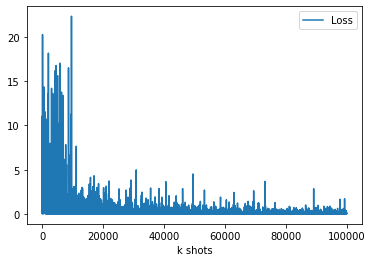

In [14]:
plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')